In [594]:
import psycopg2
import psycopg2.extras
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

def gp_connect():
    try:
        db = psycopg2.connect(dbname="postgres",
                              user="student",
                              password="JvLda93aA",
                              host="158.160.52.106",
                              port="5432")
                 # Connect () may also be used a large string parameter,
                 # For example, "host = localhost port = 5432 user = postgres password = postgres dbname = test"
        return db
    except psycopg2.DatabaseError as e:
        print("could not connect to Greenplum server",e)
        
conn = gp_connect()
cur = conn.cursor()

import warnings
warnings.filterwarnings('ignore')

In [595]:
#датафрейм с клиентами
df_client = pd.read_sql("SELECT * FROM msu_analytics.client", conn)
#датафрейм с аккаунтами
df_account = pd.read_sql("SELECT * FROM msu_analytics.account", conn)
#датафрейм с заявками клиентов на игры
df_application = pd.read_sql("SELECT * FROM msu_analytics.application", conn)
#датафрейм с играми
df_game = pd.read_sql("SELECT * FROM msu_analytics.game", conn)

In [600]:
#расчёт кол-ва посетителей в неделю
df_client['visit_dttm'] = pd.to_datetime(df_client['visit_dttm']) - pd.to_timedelta (7, unit='d')
df_cl_W = df_client.groupby([pd.Grouper(key='visit_dttm', freq='W-MON')])['client_rk'].count().reset_index().sort_values('visit_dttm')
df_cl_W.rename(columns = {'client_rk':'count_clients'}, inplace = True)

#объединение датафреймов клиенты и аккаунты по неделям. Получаем список зарегистрировавшихся
df_registred = df_account.merge(df_client, left_on='client_rk', right_on='client_rk', how = 'inner')

#расчёт кол-ва зарегистрированных аккаунтов в неделю
df_registred['visit_dttm'] = pd.to_datetime(df_registred['visit_dttm']) - pd.to_timedelta (7, unit='d')
df_ac_W = df_registred.groupby([pd.Grouper(key='visit_dttm', freq='W-MON')])['account_rk'].count().reset_index().sort_values('visit_dttm')
df_ac_W.rename(columns = {'account_rk':'count_accounts_ac'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенную неделю и кол-во зарегистрировавшихся из них
df_reg_from_all = df_ac_W.merge(df_cl_W, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')


#объединение датафреймов заявки и аккаунты по неделям. Получаем список оставивших заявки
df_applic_from_acc = df_registred.merge(df_application, left_on='account_rk', right_on='account_rk', how = 'inner')

#расчёт кол-ва заявок в неделю
df_applic_from_acc['visit_dttm'] = pd.to_datetime(df_applic_from_acc['visit_dttm']) - pd.to_timedelta (7, unit='d')
df_ap_W = df_applic_from_acc.groupby([pd.Grouper(key='visit_dttm', freq='W-MON')])['account_rk'].count().reset_index().sort_values('visit_dttm')
df_ap_W.rename(columns = {'account_rk':'count_accounts_ap'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенную неделю и кол-во оставивших заявку из них
df_applic_from_all = df_ap_W.merge(df_cl_W, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')


#объединение датафреймов заявок и игр по неделям. Получаем список игр
df_played_games = df_applic_from_acc.merge(df_game, left_on='game_rk', right_on='game_rk', how = 'inner')

#расчёт кол-ва проведенных игр в неделю
df_played_games['visit_dttm'] = pd.to_datetime(df_played_games['visit_dttm']) - pd.to_timedelta (7, unit='d')
df_played_games = df_played_games.loc[df_played_games['game_flg'] == 1]
df_g_W = df_played_games.groupby([pd.Grouper(key='visit_dttm', freq='W-MON')])['game_rk'].count().reset_index().sort_values('visit_dttm')
df_g_W.rename(columns = {'game_rk':'count_games'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенную неделю и кол-во сходивших на квест из них
df_played_from_all = df_g_W.merge(df_cl_W, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')

In [602]:
#расчёт кол-ва посетителей в месяц
df_client['visit_dttm'] = pd.to_datetime(df_client['visit_dttm']) - pd.to_timedelta (1, unit='m')
df_cl_M = df_client.groupby([pd.Grouper(key='visit_dttm', freq='M')])['client_rk'].count().reset_index().sort_values('visit_dttm')
df_cl_M.rename(columns = {'client_rk':'count_clients'}, inplace = True)

#объединение датафреймов клиенты и аккаунты по месяцам. Получаем список зарегистрировавшихся
df_registred_M = df_account.merge(df_client, left_on='client_rk', right_on='client_rk', how = 'inner')

#расчёт кол-ва зарегистрированных аккаунтов в месяц
df_registred['visit_dttm'] = pd.to_datetime(df_registred_M['visit_dttm']) - pd.to_timedelta (1, unit='m')
df_ac_M = df_registred.groupby([pd.Grouper(key='visit_dttm', freq='M')])['account_rk'].count().reset_index().sort_values('visit_dttm')
df_ac_M.rename(columns = {'account_rk':'count_accounts_ac'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенный месяц и кол-во зарегистрировавшихся из них
df_reg_from_all_M = df_ac_M.merge(df_cl_M, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')


#объединение датафреймов заявки и аккаунты по месяцам. Получаем список оставивших заявки
df_applic_from_acc_M = df_registred_M.merge(df_application, left_on='account_rk', right_on='account_rk', how = 'inner')

#расчёт кол-ва заявок в месяц
df_applic_from_acc_M['visit_dttm'] = pd.to_datetime(df_applic_from_acc_M['visit_dttm']) - pd.to_timedelta (1, unit='m')
df_ap_M = df_applic_from_acc_M.groupby([pd.Grouper(key='visit_dttm', freq='M')])['account_rk'].count().reset_index().sort_values('visit_dttm')
df_ap_M.rename(columns = {'account_rk':'count_accounts_ap'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенный месяц и кол-во оставивших заявку из них
df_applic_from_all_M = df_ap_M.merge(df_cl_M, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')


#объединение датафреймов заявок и игр по месяцам. Получаем список игр
df_played_games_M = df_applic_from_acc_M.merge(df_game, left_on='game_rk', right_on='game_rk', how = 'inner')

#расчёт кол-ва проведенных игр в месяц
df_played_games_M['visit_dttm'] = pd.to_datetime(df_played_games_M['visit_dttm']) - pd.to_timedelta (1, unit='m')
df_played_games_M = df_played_games_M.loc[df_played_games_M['game_flg'] == 1]
df_g_M = df_played_games_M.groupby([pd.Grouper(key='visit_dttm', freq='M')])['game_rk'].count().reset_index().sort_values('visit_dttm')
df_g_M.rename(columns = {'game_rk':'count_games'}, inplace = True)

#датафрейм с общим кол-вом посетителей в определенный месяц и кол-во сходивших на квест из них
df_played_from_all_M = df_g_M.merge(df_cl_M, left_on='visit_dttm', right_on='visit_dttm', how = 'inner')

''

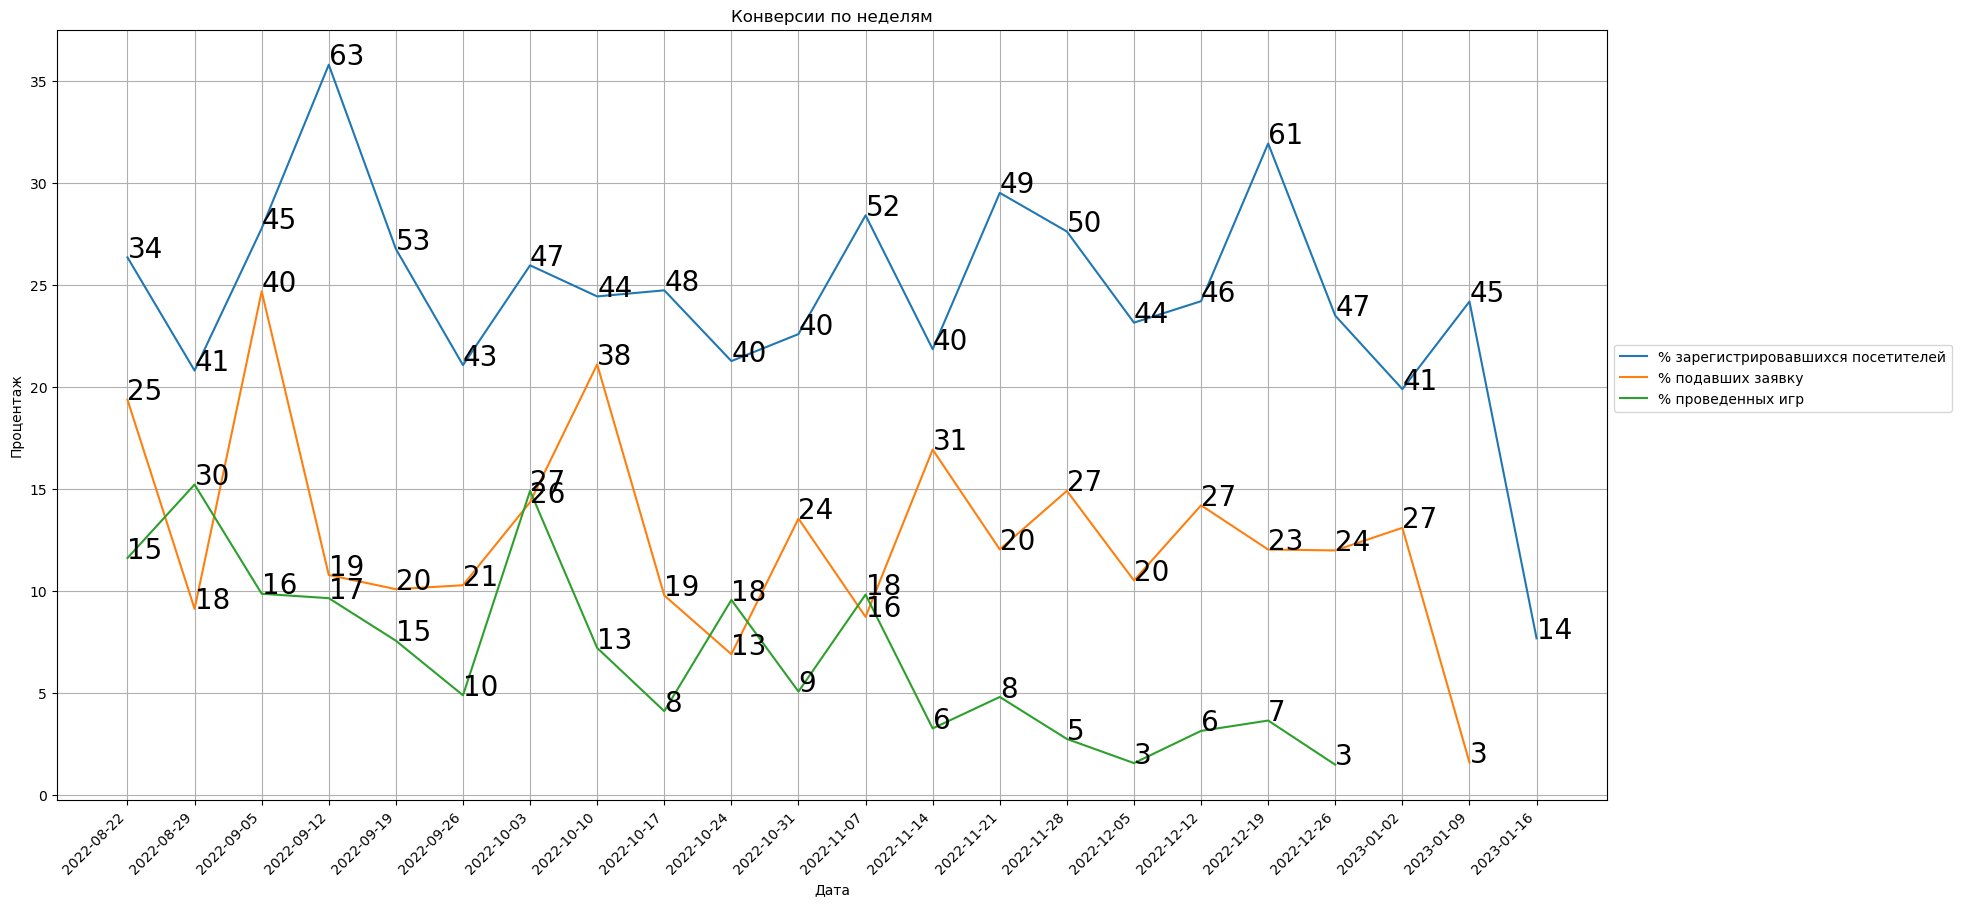

In [603]:
plt.figure(figsize=(20, 10))
plt.plot(df_reg_from_all.visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_reg_from_all.count_accounts_ac/df_reg_from_all.count_clients*100)
for i in range(len(df_reg_from_all.index)):
    plt.annotate(int(df_reg_from_all.iloc[[i]].count_accounts_ac),
                (df_reg_from_all.iloc[[i]].visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_reg_from_all.iloc[[i]].count_accounts_ac/df_reg_from_all.iloc[[i]].count_clients*100), fontsize = 20)
    
plt.plot(df_applic_from_all.visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_applic_from_all.count_accounts_ap/df_applic_from_all.count_clients*100)
for i in range(len(df_applic_from_all.index)):
    plt.annotate(int(df_applic_from_all.iloc[[i]].count_accounts_ap),
                (df_applic_from_all.iloc[[i]].visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_applic_from_all.iloc[[i]].count_accounts_ap/df_applic_from_all.iloc[[i]].count_clients*100), fontsize = 20)

plt.plot(df_played_from_all.visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_played_from_all.count_games/df_played_from_all.count_clients*100)
for i in range(len(df_played_from_all.index)):
    plt.annotate(int(df_played_from_all.iloc[[i]].count_games),
                (df_played_from_all.iloc[[i]].visit_dttm.dt.strftime('%Y-%m-%d'), 
         df_played_from_all.iloc[[i]].count_games/df_played_from_all.iloc[[i]].count_clients*100), fontsize = 20)

    
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.title('Конверсии по неделям')
plt.xlabel('Дата')
plt.ylabel('Процентаж')
plt.legend(['% зарегистрировавшихся посетителей','% подавших заявку','% проведенных игр'], loc=2, bbox_to_anchor=(1, 0.6))
;

Конверсии строятся относительно даты, когда клиент заходил на сайт
На графике недельных конверсий можно наблюдать достаточно неравномерные движение графиков. Присутствует несколько драматических падений
Но ввиду того, что от недели к неделе время от времени возникает сильное различие в значениях конверсий относительно самих себя, трудно выделить какую-то зависимость и поэтому стоит посмотреть на график месячных конверсий.

''

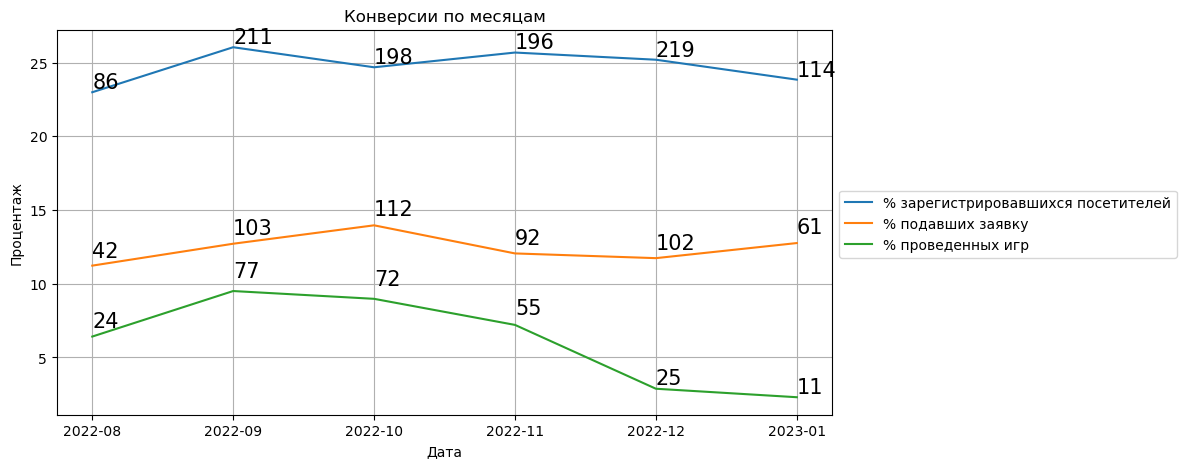

In [604]:
plt.figure(figsize=(10, 5))


plt.plot(df_reg_from_all_M.visit_dttm.dt.strftime('%Y-%m'), 
         df_reg_from_all_M.count_accounts_ac/df_reg_from_all_M.count_clients*100)
for i in range(len(df_reg_from_all_M.index)):
    plt.annotate(int(df_reg_from_all_M.iloc[[i]].count_accounts_ac),
                (df_reg_from_all_M.iloc[[i]].visit_dttm.dt.strftime('%Y-%m'), 
         df_reg_from_all_M.iloc[[i]].count_accounts_ac/df_reg_from_all_M.iloc[[i]].count_clients*101), fontsize = 15)


plt.plot(df_applic_from_all_M.visit_dttm.dt.strftime('%Y-%m'), 
         df_applic_from_all_M.count_accounts_ap/df_applic_from_all_M.count_clients*100)
for i in range(len(df_applic_from_all_M.index)):
    plt.annotate(int(df_applic_from_all_M.iloc[[i]].count_accounts_ap),
                (df_applic_from_all_M.iloc[[i]].visit_dttm.dt.strftime('%Y-%m'), 
         df_applic_from_all_M.iloc[[i]].count_accounts_ap/df_applic_from_all_M.iloc[[i]].count_clients*105), fontsize = 15)
    
    
plt.plot(df_played_from_all_M.visit_dttm.dt.strftime('%Y-%m'), 
         df_played_from_all_M.count_games/df_played_from_all_M.count_clients*100)
for i in range(len(df_played_from_all_M.index)):
    plt.annotate(int(df_played_from_all_M.iloc[[i]].count_games),
                (df_played_from_all_M.iloc[[i]].visit_dttm.dt.strftime('%Y-%m'), 
         df_played_from_all_M.iloc[[i]].count_games/df_played_from_all_M.iloc[[i]].count_clients*110), fontsize = 15)
    
    
plt.grid()
plt.title('Конверсии по месяцам')
plt.xlabel('Дата')
plt.ylabel('Процентаж')
plt.legend(['% зарегистрировавшихся посетителей','% подавших заявку','% проведенных игр'], bbox_to_anchor=(1, 0.6))
;

Данный график выглядит более вменяемо. По нему можно точно сказать, что % регистраций, вцелом, не меняется от месяца к месяцу. Но само количество посетителей больше чем в 2 раза, значений в августе и январе.
Малое количество посетителей в августе можно объяснить возможным сезоном отпусков, либо тем, что многие дети находятся не в городе (очевидно, что % семей с детьми, посещающих квесты, не маленький).
В январе же наблюдается падение ввиду прошествия новогодних праздников, к проведению которых многие подготовились ещё в декабре, чем и можно объяснить наибольшее абсолютное кол-во регистраций.
Тем не менее, нужно повышать процент регистраций. Это можно делать путём предложения моментальных скидок при регистрации, всё это располагать в всплывающем окне при входе на сайт. Также стоит заказывать рекламные видеоролики и статьи о квестах, где будут рассказывать обо всех плюсах.

Подача заявки тоже вцелом постоянна в процентном соотношении. В абсолютных значениях заметна аналогичная разница в определенные месяцы.

Проведенные игры же, наиболее часто проводятся в осенний период, а к зиме падают вплоть до минимальных значений. Январь можно объяснить только тем, что люди регистрируются в январе "на перспективу". Чтобы повышать интерес к походам на квесты в непопулярные периоды, можно устраивать конкурсы среди прошедших квест, например на скорость. Какая команда быстрее всех пройдёт квест в этом месяце, получат, допустим, депозит в ресторане на всю команду или дополнительный квест, например.